<a href="https://colab.research.google.com/github/dellaanima/AIFFEL_QUEST/blob/master/QUEST06/QUEST06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QUEST 06


**[Quest Guide Line]**
- Data
	- 뉴스 기사 데이터, text와 headlines 두 가지 열 존재

- Tasks
  1. 추상적 요약
    - text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델 학습
    - 데이터 전처리 진행
    - 모델 구조 어텐션 메커니즘 사용
  2. 추출적 요약
    - text열만을 사용
    - Summa의 summarize를 사용


**[평가문항	& 상세기준]**
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
- 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
- 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.

3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.
- 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.


# 목차
- Import Modules
- Downloading Data
- Data Preprocessing
  1. 데이터 정리
      - 결측치 & 중복 데이터 제거
      - 텍스트 정규화
      - 불용어 제거
  2. 모델 학습을 위한 데이터 처리
    - text , headlines 의 최대 길이 지정
    - decoder 입출력을 위한 칼럼 생성(시작 토큰, 종료 토큰 추가 된 데이터 생성)
    - encoder, decoder 입출력 값 생성 (numpy)
    - train test split
  3. Word to index
    - 단어 집합 생성
    - Encoder Word to Index 적용
    - Decoder Word to index 적용
  4. 패딩 추가
- 모델 설계
- 모델 훈련
- 인퍼런스 모델 구현
  - Endoer Model
  - Decoder Model
  - Word 를 Sequence 로 만드는 함수
- 모델 테스트
- 추출적 요약
- 평가 및 정리
  - 추상적 요약 모델 평가
  - 추출적 요약 모델 평가
  - 전체적인 분석 및 개선 방안 제시

# Import modules

In [ ]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Downloading Data


In [ ]:
# 데이터 다운로드
# nltk패키지에서 불용어 사전 다운로드
# urllib을 이용하여 뉴스 기사 데이터를 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [ ]:
data.sample(10)

,headlines,text
17846,Rahul 1st Indian in 39 yrs to hit ton in 4th i...,Indian opener KL Rahul became the first Indian...
8258,"My patriotism doubted, 20 years of hard work i...",Reacting to the allegations levelled against h...
32544,Internet suspended in Aligarh amid AMU Jinnah ...,Internet services in Uttar Pradesh's Aligarh h...
69921,Facebook tests 'Snooze' feature to temporarily...,Social media giant Facebook is testing a 'Snoo...
95990,Trump's daughter becomes unpaid White House em...,US President Donald Trump's daughter Ivanka Tr...
34167,Apple's proposed acquisition of Shazam being i...,The European Union has launched an investigati...
53840,"11,500-yr-old DNA reveals new population of Na...",Genetic analysis of a six-week-old infant that...
95536,Media owners being controlled by Modi govt: Ch...,Congress leader P Chidambaram on Saturday accu...
12264,Rafale only reason to send Verma on leave at 3...,After CBI Director Alok Verma was sent on leav...
53750,"Worry about Kim's mental health, not Trump's: ...",Defending President Donald Trump's tweet about...


# Data Preprocessing

  1. 데이터 정리
      - Text 칼럼에 대한 중복 데이터 제거
      - 결측치 처리
      - 텍스트 데이터 전처리 + 텍스트 정규화 + 불용어 제거
  2. 모델 학습을 위한 데이터 처리
    - text , headlines 의 최대 길이 지정
    - decoder 입출력을 위한 칼럼 생성(시작 토큰, 종료 토큰 추가 된 데이터 생성)
    - encoder, decoder 입출력 값 생성 (numpy)
    - train test split
  3. Word to index
   -

## 1. 데이터 정리


### Text 칼럼에 대한 중복 데이터 제거

- 중복을 제외한다면 text에는 98,360개, headlines에는 98,280개의 유니크한 데이터가 존재.
headlines에는 간단한 요약들도 많아서 Text가 달라도 headlines는 동일할 수 있다. 하지만 Text 자체가 중복이 된 경우는 중복 샘플이므로 Text 칼럼에 대한 중복 샘플만 제거

  (전체 샘플수는 98401개 이므로 text 열에서 41개 중복이 존재하는 것을 알 수 있음.)

In [ ]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [ ]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 결측치 처리

* 결측치가 존재하지 않음.

In [ ]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 텍스트 데이터 전처리 + 텍스트 정규화 + 불용어 제거



**텍스트 정규화(text normalization)** 란, 같은 의미이지만 다른 표현으로 사용되는 단어들을 같은 단어로 통일시켜주는 역할로, `it'll` = `it will`, `mustn't` = `must not` 와 같은 의미의 표현들을 통일시키는 과정. 텍스트 정규화를 통해 기계의 연산량을 줄일 수 있다.

In [ ]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


**불용어** 란 자연어 처리를 할 때 의미를 분석하고 요약하는 데는 거의 의미가 없는 단어이다.

* NLTK 에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거한다.
* 불용어 리스트에는 총 179개의 불용어가 존재

In [ ]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

데이터 전처리 함수 `preprocess_sentence` 정의
* 텍스트 소문자화
* html 태그 제거
* 괄호로 닫힌 문자열 (...) 제거
* " 제거
* 약어 정규화
* 소유격 제거
* 숫자, 특수문자 공백으로 변환
* mm 작업
* if 조건문 이용해서, text 에 있는 불용어만 제거, headlines 에 있는 불용어는 제거하지 않음.
  * Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 **headlines**에는 남아 있는 게 더 좋음

In [ ]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

전체 text에 대하여 전처리 진행
* 전처리 과정을 거친 text 데이터는 clean_text라는 빈 리스트에 추가
* 불용어 제거, `remove_stopwords=True`

In [ ]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다.
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

전체 headlines에 대하여 전처리 과정
* 전처리 과정을 거친 headlines 데이터는 clean_headlines 이라는 빈 리스트에 추가
* 불용어 제거 X, `remove_stopwords=False`

In [ ]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

<ipython-input-14-1298778c7c93>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


* 전처리 후에, 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있음

* 이후 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체하고, 결측치 확인

In [ ]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

data.isnull().sum()

결측치 없음

- 추후에 Runtime 끊기는 상황을 대비하여, 전처리를 수행한 csv 파일을 따로 저장함

In [ ]:

output_file_path = 'cleaned_data.csv'
data.to_csv(output_file_path, index=False)

print("Data saved to CSV file:", output_file_path)

Data saved to CSV file: cleaned_data.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Runtime 끊겼으면 여기서부터 실행

input_file = '/content/drive/MyDrive/cleaned_data.csv'
data = pd.read_csv(input_file)


In [ ]:
data

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
2,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
3,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
4,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...
...,...,...,...,...
96533,crpf jawan axed to death by maoists in chhatti...,crpf jawan tuesday axed death sharp edged weap...,sostoken crpf jawan axed to death by maoists i...,crpf jawan axed to death by maoists in chhatti...
96534,first song from sonakshi sinha noor titled uff...,uff yeh first song sonakshi sinha starrer upco...,sostoken first song from sonakshi sinha noor t...,first song from sonakshi sinha noor titled uff...
96535,the matrix film to get reboot reports,according reports new version science fiction ...,sostoken the matrix film to get reboot reports,the matrix film to get reboot reports eostoken
96536,snoop dogg aims gun at clown dressed as trump ...,new music video shows rapper snoop dogg aiming...,sostoken snoop dogg aims gun at clown dressed ...,snoop dogg aims gun at clown dressed as trump ...


## 모델 학습을 위한 데이터 처리



### text , headlines 의 최대 길이 지정


- 훈련에 사용할 샘플의 최대 길이를 정해주기 위해서`text` 와 `headlines` 의 최소, 최대, 평균 길이를 구하고 길이 분포를 시각화해봄

text 의 최소 길이 : 1
text 의 최대 길이 : 44
text 의 평균 길이 : 35.036607346329944
headlines 의 최소 길이 : 1
headlines 의 최대 길이 : 12
headlines 의 평균 길이 : 9.251455385444073


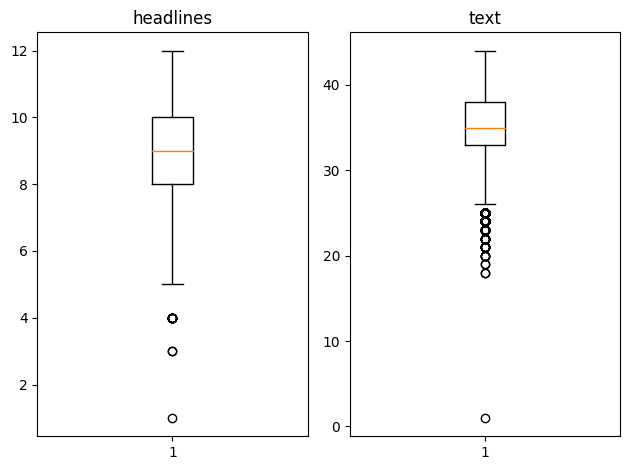

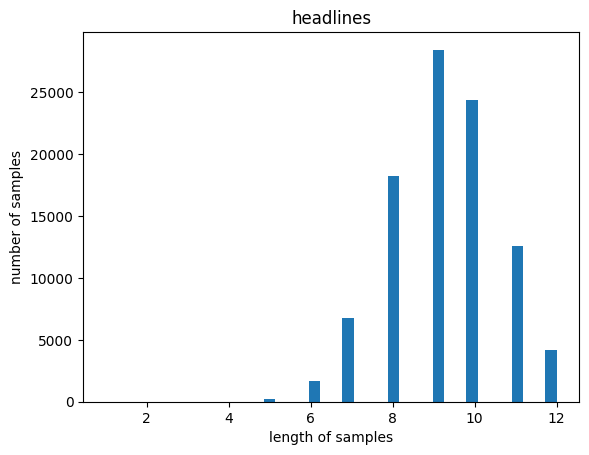

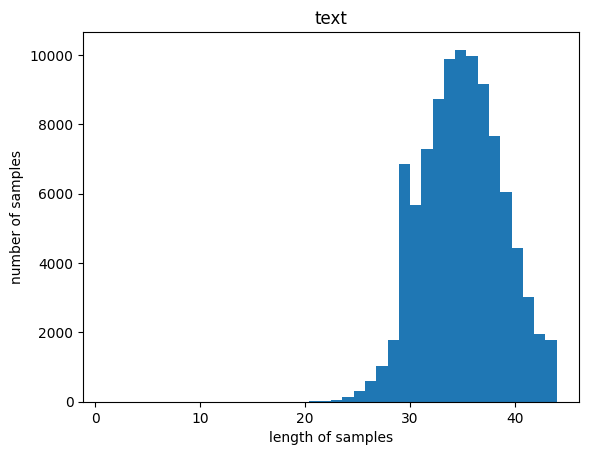

In [ ]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('text 의 최소 길이 : {}'.format(np.min(text_len)))
print('text 의 최대 길이 : {}'.format(np.max(text_len)))
print('text 의 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines 의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines 의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines 의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

[시각화 결과 분석]
* `text`의 경우, 대체적으로 25 ~ 45 사이의 길이 분포를 구성
* `headlines`의 경우, 대체적으로 6 ~ 13 사이의 길이 분 구성

* text와 headlines의 적절한 최대 길이를 44 와 12 로 임의로 설정했음.

In [ ]:
text_max_len = 44
headlines_max_len = 12

In [ ]:
def below_threshold_len(max_len, nested_list):  # 데이터의 몇 %가 해당하는지 계산하는 함수
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [ ]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 44 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 12 이하인 샘플의 비율: 1.0


- 최대 길이 적용


In [ ]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플 수 :',(len(data)))

전체 샘플 수 : 96538


### decoder 입출력을 위한 칼럼 생성(시작 토큰, 종료 토큰 추가 된 데이터 생성)


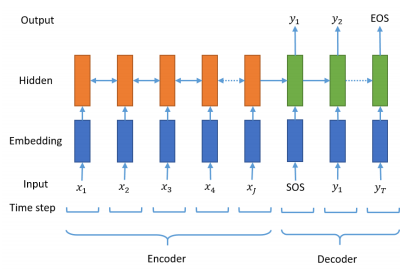

- Decoder 는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간 문장 생성을 멈춘다.
- 즉, seq2seq 훈련을 위해서는 Decoder 의 입력(decoder_input)과 출력(decoder_target) 에 시작 토큰과 종료 토큰을 추가해줘야함
- decoder_input 의 맨 앞에 시작 토큰 (sostoken)
- decoder_target 의 맨 뒤에 종료 토큰 (eostoken)

  (start of a sequence와 end of a sequence)

In [ ]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
2,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
3,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
4,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


### encoder, decoder 입출력 값 생성 (numpy) 및 데이터 고르게 섞기


In [ ]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)


print("Before Shuffling : ")
print(encoder_input[0:5])
print(decoder_input[0:5])
print(decoder_target[0:5])

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

print("\n After Shuffling : ")
print(encoder_input[0:5])
print(decoder_input[0:5])
print(decoder_target[0:5])

Before Shuffling : 
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years'
 'pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india would better authorities would served notice first pu

### train test split




* 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리할 예정
* 전체 데이터 크기에 0.2를 곱하여, 테스트 데이터의 크기를 정의
* 앞서 정의한 테스트 데이터의 갯수를 이용하여 전체 데이터를 훈련 데이터와 테스트 데이터로 양분
* 총 훈련 데이터는 77,231개이고, 테스트 데이터는 19,307개

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

테스트 데이터의 수 : 19307
훈련 데이터의 개수 : 77231
훈련 레이블의 개수 : 77231
테스트 데이터의 개수 : 19307
테스트 레이블의 개수 : 19307


## Word to Index



### 단어 집합(vocabulary) 생성

In [ ]:
src_tokenizer = Tokenizer() # 토크나이저 정의

# fit_on_texts 함수는 Keras의 Tokenizer 객체에 속하는 메서드 중 하나로, 텍스트 데이터로부터 단어 집합(vocabulary)을 생성
#단어 집합(vocabulary)은 텍스트 데이터에 등장하는 모든 단어들을 유니크한 정수 인덱스로 매핑한 사전(dictionary) 형태로 구성됩니다. (즉, 각 단어들은 고유한 번호로 인덱스화)

src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성


In [ ]:
# src_tokenizer.word_index 에 단어 집합이 생서됨. 해당 단어 집합을 출력해보고 싶었으나, 너무 커서 그런지 계속 에러가 나서, index 값을 1로 가지는 key : value 에 대해서만 출렫해봄
words_with_value_1 = {word: index for word, index in src_tokenizer.word_index.items() if index == 1}
print(words_with_value_1)

{'said': 1}


.
* 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외한다.

* `src_tokenizer.word_counts.items()` 를 사용하여 등장 빈도수가 8회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해본다.

In [ ]:
threshold = 8
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68781
등장 빈도가 7번 이하인 희귀 단어의 수: 48349
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20432
단어 집합에서 희귀 단어의 비율: 70.29412192320554
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.9025906169029367


* 등장 빈도가 threshold 값인 7회 이하인 단어들은 단어 집합에서 약 70% 를 차지함.
* 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.89% 밖에 되지 않음.

* 등장 빈도가 7회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거한다.

* 단어 집합의 크기를 20,000으로 제한한다.

In [ ]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.



### Encoder Word to Index 적용

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[0])

[920, 2878, 2388, 1368, 10544, 8329, 71, 386, 369, 67, 2, 20, 207, 3847, 9510, 4868, 14145, 17279, 1924, 244, 727, 77, 3, 13, 1368, 2224, 3656, 92, 91, 412, 1105, 67, 2813, 26, 2146, 4869]


### Decoder Word to Index 적용

In [ ]:
# 전체 단어 집합과 각 단어에 대한 빈도수를 계산
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
# 등장 빈도수가 8회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29836
등장 빈도가 6번 이하인 희귀 단어의 수: 20419
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9417
단어 집합에서 희귀 단어의 비율: 68.43745810430353
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.426888350722671


In [ ]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words = tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[0])
print('target')
print('decoder ',decoder_target_train[0])

input
input  [1, 332, 2414, 7, 9, 7123, 8, 1376]
target
decoder  [332, 2414, 7, 9, 7123, 8, 1376, 2]


* 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있다.

* decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이므로 길이가 0이 된 요악문의 실제 길이는 1로 나올 것이다.

* 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장하고 샘플들은 모두 삭제한다.

In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77230
훈련 레이블의 개수 : 77230
테스트 데이터의 개수 : 19307
테스트 레이블의 개수 : 19307


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## 패딩 추가

* 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해준다.

In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# 모델 설계



## Encoder Model 정의



* 임베딩 벡터의 차원을 128로 정의하고, hidden state의 크기를 256으로 정의
* 이후, 인코더 부분의 LSTM은 총 3개의 층으로 구성
* 인코더의 최종 출력 벡터는 디코더로 보낼 예정

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

## Decoder Model 정의



* 디코더의 임베딩 층을 설계하는 것은 인코더와 동일
* LSTM 층은 initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줌

In [ ]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층 설계
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

## Encoder와 Decoder 합치기

In [ ]:
# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 44)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 44, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 44, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

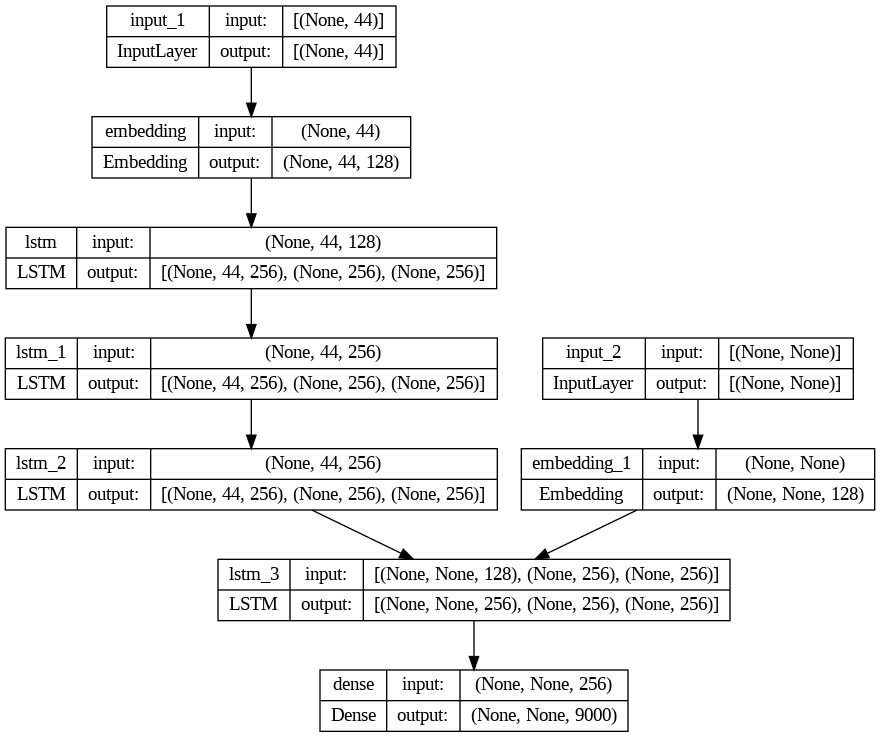

In [ ]:
from keras.utils import plot_model
import pydot

# 모델을 시각화하여 'model.png'로 저장
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


## Attention Model 어텐션 메커니즘 사용하기 (추상적 요약)

* model에서 어텐션 함수를 이용할 예정

In [ ]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 44)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 44, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 44, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

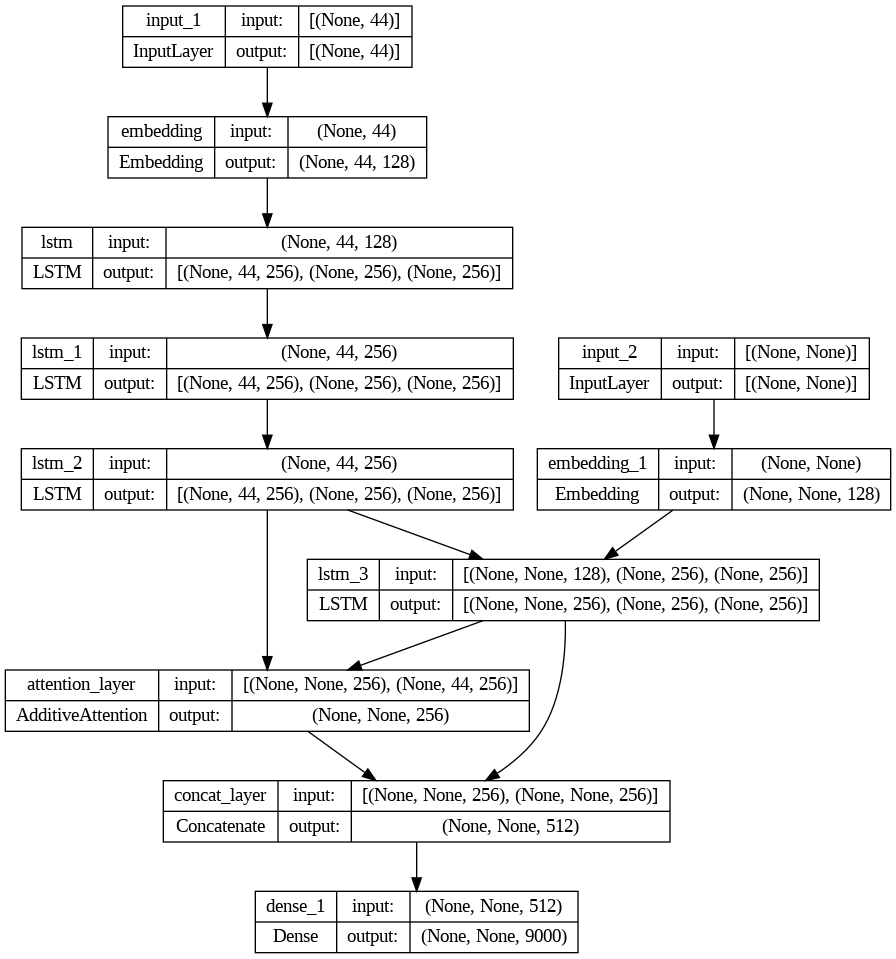

In [ ]:
from keras.utils import plot_model
import pydot

# 모델을 시각화하여 'model.png'로 저장
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


# 모델 훈련

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
302/302 [==============================] - 203s 618ms/step - loss: 5.5316 - val_loss: 5.1038
Epoch 2/50
302/302 [==============================] - 184s 610ms/step - loss: 4.9444 - val_loss: 4.7363
Epoch 3/50
302/302 [==============================] - 184s 608ms/step - loss: 4.6196 - val_loss: 4.4704
Epoch 4/50
302/302 [==============================] - 183s 606ms/step - loss: 4.3575 - val_loss: 4.2833
Epoch 5/50
302/302 [==============================] - 183s 606ms/step - loss: 4.1564 - val_loss: 4.1320
Epoch 6/50
302/302 [==============================] - 183s 606ms/step - loss: 3.9881 - val_loss: 4.0299
Epoch 7/50
302/302 [==============================] - 182s 603ms/step - loss: 3.8453 - val_loss: 3.9399
Epoch 8/50
302/302 [==============================] - 182s 603ms/step - loss: 3.7226 - val_loss: 3.8784
Epoch 9/50
302/302 [==============================] - 182s 603ms/step - loss: 3.6157 - val_loss: 3.8113
Epoch 10/50
302/302 [==============================] - 182s 604m

* early stopping 해서, validation loss가 더 이상 낮아지지 않을 때(2회 사이), 학습을 종료
* model의 loss는 약 2.5661이지만, validation loss는 3.5296 이어서 다소 오버피팅 된 모델이 생성된 것 같다.

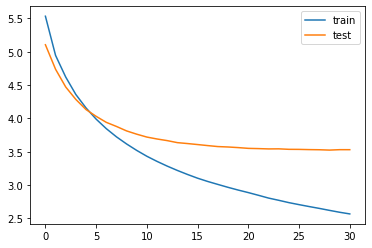

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

훈련 데이터와 테스트 데이터의 loss를 시각화
훈련 데이터와 테스트 데이터 loss의 격차를 보면, 훈련 데이터가 overfitting이 되었다고 판단할 수 있음

# 인퍼런스 모델 구현

## word2index, index2word 구하기

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

## Encoder Model

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

## Decoder Model

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

## word를 Sequence로 만드는 함수

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 모델 테스트

주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만든다.

이때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만든다.

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
for i in range(20, 40):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : facebook coo sheryl sandberg twitter co founder ceo jack dorsey seek election walt disney board according filing disney said become increasingly difficult two avoid conflicts relating board matters former starbucks ceo smith also leave board following rules specify retirement age 
실제 요약 : fb coo twitter ceo to leave disney board 
예측 요약 :  twitter ceo quits facebook over paris deal


원문 : irrfan khan saba qamar starrer hindi medium named best film rd edition filmfare awards irrfan named best actor hindi medium vidya balan best actress tumhari sulu meanwhile rajkummar rao starrer newton best film filmfare award 
실제 요약 : hindi medium named best film at filmfare awards 
예측 요약 :  irrfan irrfan khan to star in hindi medium report


원문 : student kolkata st paul cathedral mission college allegedly stripped naked filmed seniors questioned funds used college fest filed police complaint video incident circulated college west bengal education minister partha chatterjee said strict action take

# 추출적 요약 (Extractive Summarization)

* 패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize로 간단하게 구현

In [ ]:
from summa.summarizer import summarize
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
data['summary'] = data['text'].apply(lambda x: summarize(x, ratio=0.5))

In [ ]:
data.sample(10)

,headlines,text,summary
20523,US man yells 'Jesus is coming' before stabbing...,A man was shot in the leg by his neighbour in ...,A man was shot in the leg by his neighbour in ...
68255,World Tourism Day celebrated on September 27,World Tourism Day is celebrated on September 2...,World Tourism Day is celebrated on September 2...
65102,Taj Mahal sits on stolen property: Subramanian...,BJP leader Subramanian Swamy has alleged Taj M...,He said there are documents that also suggest ...
10921,"Thor actor shares video of India traffic, call...","'Thor' actor Chris Hemsworth, who's in India t...","In another video, Hemsworth said, ""No one's......"
10102,PM Modi is my friend and now Ivanka's: Trump a...,While introducing his daughter Ivanka to India...,While introducing his daughter Ivanka to India...
89824,Scientists generate hydrogen fuel from pollute...,Belgian scientists have developed a device tha...,The compartments for purifying air and storing...
18897,I've become Shah Rukh Khan because of Salman a...,"Actor Shah Rukh Khan, who recently appeared on...","Actor Shah Rukh Khan, who recently appeared on..."
38443,"Mumbai witnessed 12 major fires, 22 deaths in ...",Mumbai has witnessed 12 major fires which resu...,Mumbai has witnessed 12 major fires which resu...
16064,Doctors treat patients under candlelight due t...,Doctors at a government hospital in Odisha's M...,Doctors at a government hospital in Odisha's M...
60401,What was the answer that won Manushi the Miss ...,"In Miss World 2017's final round, India's Manu...",


In [ ]:
for i in range(40, 60):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("추출 요약 :", data['summary'][i])
    print("\n")

원문 : Ex-ICICI Bank CEO Chanda Kochhar said she's "utterly disappointed, hurt and shocked" by the bank's decision to terminate her. Kochhar said she served ICICI for 34 years with utmost honesty and integrity and that ultimately truth will prevail. Adding that she hasn't been given a copy of the independent probe report, Kochhar said none of ICICI's credit decisions are unilateral
실제 요약 : Shocked, hurt by ICICI's decision, truth will prevail: Kochhar
추출 요약 : Adding that she hasn't been given a copy of the independent probe report, Kochhar said none of ICICI's credit decisions are unilateral


원문 : Swedish multinational fast-fashion brand Hennes & Mauritz AB (H&M) has hired Christopher Wylie, the whistleblower who exposed Facebook's Cambridge Analytica data scandal. WylieÃ¢ÂÂs focus will be to help get better insights on customers, products and markets and support work on sustainable and ethical artificial intelligence, H&M spokesperson said. Wylie is a former employee of Cambridge Ana

# 평가 및 정리




## 추상적 요약 모델 평가

ROUGE 지표 사용

- Rouge 스코어는 자동 요약 시스템의 출력 요약과 실제 인간이 작성한 요약 사이의 유사성을 평가하는 메트릭입니다. 일반적으로 Rouge 스코어는 Precision, Recall, 그리고 F1-score로 표현

    Precision (정밀도): 자동 요약의 출력에 있는 단어 중에서 실제 요약에 있는 단어와 일치하는 비율을 나타냅니다. 높은 정밀도는 자동 요약이 정확한 단어를 선택하는 데 능숙하다는 것을 의미합니다.

    Recall (재현율): 실제 요약에 있는 단어 중에서 자동 요약의 출력에 있는 단어와 일치하는 비율을 나타냅니다. 높은 재현율은 자동 요약이 가능한 많은 실제 요약을 재현한다는 것을 의미합니다.

    F1-score: Precision과 Recall의 조화 평균으로 계산되며, Precision과 Recall을 모두 고려하여 자동 요약의 성능을 평가하는 데 사용됩니다.

- Rouge 스코어는 일반적으로 0과 1 사이의 값을 가지며, 높을수록 자동 요약의 품질이 높다고 볼 수 있습니다. 하지만 절대적인 성능 평가에는 한계가 있으며, 특히 인간의 주관적인 판단과 차이가 있을 수 있습니다. 따라서 Rouge 스코어를 사용하여 자동 요약의 품질을 평가할 때는 주의가 필요함.

In [ ]:
!python3 -m pip install rouge_score
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.2 MB/s eta 0:00:00


In [ ]:
from datasets import load_metric
rouge_score = load_metric("rouge")

<ipython-input-5-3e17c0c1122f>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_score = load_metric("rouge")


In [ ]:
reference_summary = [
    "fb coo twitter ceo to leave disney board",
    "hindi medium named best film at filmfare awards",
    "kolkata student stripped naked for asking about college fund",
    "day left for super holiday sale to end",
    "karni sena chief arrested over threat",
    "will you take bloodied pad to friend home irani on sabarimala",
    "newborn baby dumped in ant bush in tripura rescued",
    "apple iphone explodes after update in the us",
    "india africa sign yr strategic programme to ties",
    "up to start metro services in agra kanpur by"
]

generated_summary = [
    "twitter ceo quits facebook over paris deal",
    "irrfan irrfan khan to star in hindi medium report",
    "yr old student booked for copying fake student in du",
    "thomas cook presents holiday on holiday",
    "karni sena mp arrested for raping woman in ayodhya case",
    "implement doorstep ration at doorstep sanitary pads irani",
    "baby found alive after being found alive in wb",
    "apple iphone explodes users to unlock iphone location",
    "india to hold summit in us for st time in years",
    "up govt to get crore for metro mlas"
]

scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary]
)
scores

{'rouge1': AggregateScore(low=Score(precision=0.38372093023255816, recall=0.39285714285714285, fmeasure=0.38823529411764707), mid=Score(precision=0.38372093023255816, recall=0.39285714285714285, fmeasure=0.38823529411764707), high=Score(precision=0.38372093023255816, recall=0.39285714285714285, fmeasure=0.38823529411764707)),
 'rouge2': AggregateScore(low=Score(precision=0.058823529411764705, recall=0.060240963855421686, fmeasure=0.05952380952380952), mid=Score(precision=0.058823529411764705, recall=0.060240963855421686, fmeasure=0.05952380952380952), high=Score(precision=0.058823529411764705, recall=0.060240963855421686, fmeasure=0.05952380952380952)),
 'rougeL': AggregateScore(low=Score(precision=0.2558139534883721, recall=0.2619047619047619, fmeasure=0.25882352941176473), mid=Score(precision=0.2558139534883721, recall=0.2619047619047619, fmeasure=0.25882352941176473), high=Score(precision=0.2558139534883721, recall=0.2619047619047619, fmeasure=0.25882352941176473)),
 'rougeLsum': Ag

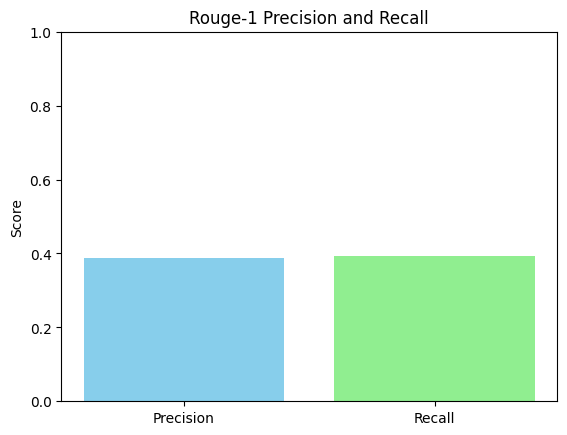

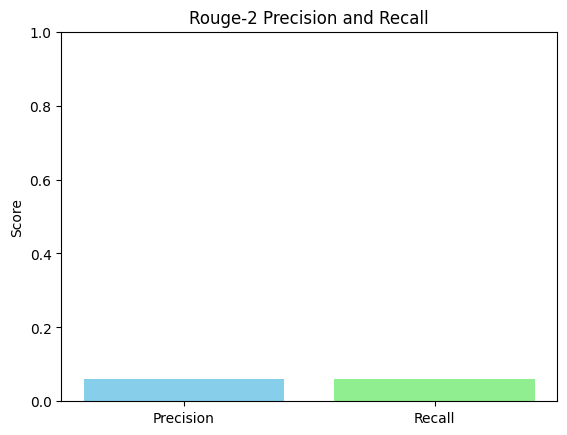

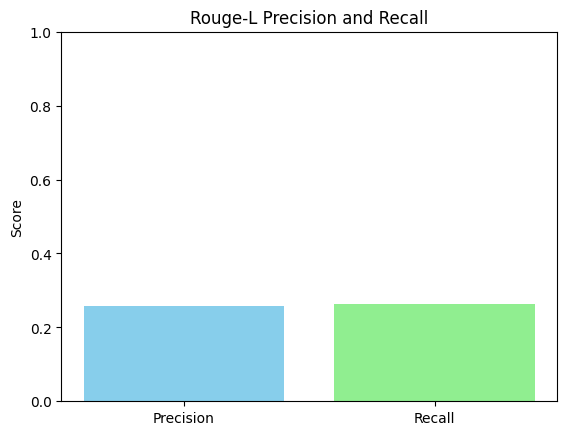

In [ ]:
import matplotlib.pyplot as plt

# Rouge 점수 추출
rouge1_precision = scores["rouge1"].mid.fmeasure
rouge1_recall = scores["rouge1"].mid.recall
rouge2_precision = scores["rouge2"].mid.fmeasure
rouge2_recall = scores["rouge2"].mid.recall
rougeL_precision = scores["rougeL"].mid.fmeasure
rougeL_recall = scores["rougeL"].mid.recall

# Rouge-1 그래프
plt.bar(["Precision", "Recall"], [rouge1_precision, rouge1_recall], color=['skyblue', 'lightgreen'])
plt.title("Rouge-1 Precision and Recall")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

# Rouge-2 그래프
plt.bar(["Precision", "Recall"], [rouge2_precision, rouge2_recall], color=['skyblue', 'lightgreen'])
plt.title("Rouge-2 Precision and Recall")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

# Rouge-L 그래프
plt.bar(["Precision", "Recall"], [rougeL_precision, rougeL_recall], color=['skyblue', 'lightgreen'])
plt.title("Rouge-L Precision and Recall")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


- 10개의 샘플에 대해서만, Rouge 지표로 모델의 성능을 평가한 내역은 위와 같습니다.
- Rouge 지표가 모델의 요약 성능을 충분히 대변하지 못한다고 판단되기에 10개 데이터 에 대해서  의미론적인 관점에서 잘 요약 했는가를 평가해봤습니다.

아래는 각 예시에 대한 의미론적 평가 결과입니다.

1. **원문:** facebook coo sheryl sandberg twitter co founder ceo jack dorsey seek election walt disney board according filing disney said become increasingly difficult two avoid conflicts relating board matters former starbucks ceo smith also leave board following rules specify retirement age
   - **실제 요약:** fb coo twitter ceo to leave disney board
   - **예측 요약:** twitter ceo quits facebook over paris deal
   - **평가:** 예측 요약은 원문과 전혀 관련이 없는 내용으로 매우 부적절한 요약입니다. 원문에서는 Facebook COO와 Twitter CEO가 디즈니 이사회 선출에 관심을 갖고 있다는 내용이 주요하게 다루어졌지만, 예측 요약은 파리 협정과 관련된 트위터 CEO의 Facebook 탈퇴를 언급하고 있습니다

2. **원문:** irrfan khan saba qamar starrer hindi medium named best film rd edition filmfare awards irrfan named best actor hindi medium vidya balan best actress tumhari sulu meanwhile rajkummar rao starrer newton best film filmfare award
   - **실제 요약:** hindi medium named best film at filmfare awards
   - **예측 요약:** irrfan irrfan khan to star in hindi medium report
   - **평가:** 예측 요약은 전체적으로 혼란스러운 내용으로, 영화 "힌디 미디엄"과 관련된 것으로 보이지만, 더 정확한 정보가 필요한 내용으로 요약되어 있습니다.

3. **원문:** student kolkata st paul cathedral mission college allegedly stripped naked filmed seniors questioned funds used college fest filed police complaint video incident circulated college west bengal education minister partha chatterjee said strict action taken accused
   - **실제 요약:** kolkata student stripped naked for asking about college fund
   - **예측 요약:** yr old student booked for copying fake student in du
   - **평가:** 측 요약은 원문의 의미와 완전히 다른 내용으로, 무작위로 임의의 내용이 요약되었습니다. 원문에서는 콜카타의 한 대학에서 발생한 논란적인 사건이 다루어졌지만, 예측 요약은 12세 학생과 델리 대학에서의 가짜 학생과 관련된 내용으로 혼란스러운 요약입니다.

4. **원문:** travel company super holiday sale offering attractive deals holiday packages come end th march travellers choose range summer holiday packages destinations like singapore dubai kashmir switzerland ladakh europe bhutan packages start include flights accommodation sightseeing
   - **실제 요약:** day left for super holiday sale to end
   - **예측 요약:** thomas cook presents holiday on holiday
   - **평가:** 예측 요약은 일부 단어만 포함하고 있으며, 원문의 내용과 전혀 다른 내용으로 매우 부적절한 요약입니다. 원문에서는 여행 회사의 슈퍼 휴가 세일이 얼마 남지 않았다는 내용이 강조되었지만, 예측 요약은 "토마스 쿡"이라는 주제와 "휴가"라는 단어만 언급하고 있습니다.

5. **원문:** karni sena chittorgarh unit president govind singh arrested declared women community ready commit jauhar release padmaavat police also arrested two members organisation earlier karni sena spokesperson said instead resorting violence women opted jauhar
   - **실제 요약:** karni sena chief arrested over threat
   - **예측 요약:** karni sena mp arrested for raping woman in ayodhya case
   - **평가:** 예측 요약은 원문의 내용과 전혀 다른 내용으로, 매우 부적절한 요약입니다. 원문에서는 Karni Sena Chittorgarh 지회 회장인 Govind Singh이 "파드마바트"의 개봉으로 인해 여성들이 "자우하르"을 하겠다는 선언으로 체포되었다는 내용이 주요하게 다루어졌지만, 예측 요약은 "카르니 세나 MP"가 "아요디아 사건"으로 인해 여성을 강간한 것으로 잘못된 정보를 담고 있습니다.

6. **원문:** speaking sabarimala temple row union minister smriti irani said would take sanitary napkins menstrual blood walk friend home would would think respectful walk house god right pray right added
   - **실제 요약:** will you take bloodied pad to friend home irani on sabarimala
   - **예측 요약:** implement doorstep ration at doorstep sanitary pads irani
   - **평가:** 예측 요약은 일부 단어만 포함하고 있으며, 원문의 내용과 다른 주제로 요약되었습니다. 원문에서는 스미트리 이라니 장관이 사바리말라 사원 논란에 대해 생리대와 생리 혈액을 가져와 친구의 집을 방문할 것이라는 발언이 주요 내용이었지만, 예측 요약은 "문 앞 물건"과 "생리대"에 대한 구현을 언급하는 임의의 내용으로 요약되었습니다.

7. **원문:** two day old newborn baby found abandoned bush tripura district said police friday many ant bites body treated infection hospital icu police added official said condition stable placed child welfare committee rehabilitation
   - **실제 요약:** newborn baby dumped in ant bush in tripura rescued
   - **예측 요약:** baby found alive after being found alive in wb
   - **평가:**  예측 요약은 일부 단어가 중복되어 혼동스러운 요약입니다. 원문에서는 트리푸라의 더스트에서 버려진 2일 된 신생아를 발견했다는 내용이 주요하게 다루어졌지만, 예측 요약은 "두 번 발견된 살아있는 아기"라는 혼란스러운 문구로 요약되었습니다.

8. **원문:** user united states claimed apple iphone exploded allegedly updated ios posted several photos exploded phone apple responded definitely expected behaviour update completed soon phone turned started smoke caught fire user said
   - **실제 요약:** apple iphone explodes after update in the us
   - **예측 요약:** apple iphone explodes users to unlock iphone location
   - **평가:** 예측 요약은 원문의 내용과 일부 부합하지 않는 문구로, 매우 부적절한 요약입니다. 원문에서는 미국의 사용자가 iOS를 업데이트 한 후에 Apple iPhone이 폭발했다는 내용이 주요하게 다루어졌지만, 예측 요약은 "Apple iPhone이 사용자의 위치를 해제하기 위해 폭발한다"는 잘못된 정보를 담고 있습니다.

9. **원문:** India and South Africa signed a three-year strategic programme of cooperation aimed at enhancing their strategic partnership. The two nations agreed to enhance ties in the economic and defense sectors, among others. The agreement came during South African President Cyril's visit to India as the chief guest for Republic Day celebrations.
  - **실제 요약:** India-Africa sign 3-yr strategic programme to ties
  - **예측 요약:** India to hold summit in US for the first time in years
India and South Africa Sign Strategic Programme
  - **평가:** 예측 요약은 원문의 내용과 완전히 다른 내용으로 혼란스러운 요약입니다. 원문에서는 인도와 남아프리카가 전략적 협력 프로그램에 서명하여 경제와 군사 분야를 포함한 관계를 강화한다는 내용이 주요하게 다루어졌지만, 예측 요약은 "인도가 여러 해 동안 처음으로 미국에서 정상회담을 개최할 것이다"라는 임의의 내용으로 요약되었습니다.

10. **원문:** The Uttar Pradesh government has decided to start metro services in Agra, Kanpur, and Meerut. The estimated cost for the two metro corridors planned in Agra is ₹8,379 crore and in Kanpur is ₹11,076 crore. The Meerut metro, which is 33.6 km long, will cost ₹13,298 crore.
  - **실제 요약:** UP to start metro services in Agra, Kanpur by 2025
  - **예측 요약:** UP govt to get ₹1,000 crore for metro MLAs
Uttar Pradesh to Start Metro Services
  - **평가:** 예측 요약은 원문의 내용과 전혀 다른 내용으로, 잘못된 요약입니다. 원문에서는 우타르 프라데시 주정부가 아그라, 캔푸르 및 메이르트에 지하철 서비스를 시작하기로 결정했다는 내용이 주요하게 다루어졌지만, 예측 요약은 "지하철 MLAs에게 1,000억 루피를 받을 것"이라는 무의미한 정보로 요약되었습니다.

## 추출적 요약 모델 평가

In [ ]:
reference_summary = [
    "Shocked, hurt by ICICI's decision, truth will prevail: Kochhar",
    "Fashion brand H&M hires Facebook data scandal whistleblower",
    "Twitter testing news-first timeline feature on Android",
    "Samsung builds world's first 1TB storage chip for smartphones"
]

generated_summary = [
    "Adding that she hasn't been given a copy of the independent probe report, Kochhar said none of ICICI's credit decisions are unilateral",
    "Swedish multinational fast-fashion brand Hennes & Mauritz AB (H&M) has hired Christopher Wylie, the whistleblower who exposed Facebook's Cambridge Analytica data scandal.",
    "Micro-blogging platform Twitter is testing a new feature on Android to put news on the top of a user's timeline.",
    "Samsung has started mass producing its one terabyte 'embedded Universal Flash Storage (eUFS) 2.1' technology for 'use in next-generation mobile applications', which it claims is the industry's first such eUFS."
]


scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary]
)
scores

{'rouge1': AggregateScore(low=Score(precision=0.22330097087378642, recall=0.6216216216216216, fmeasure=0.32857142857142857), mid=Score(precision=0.22330097087378642, recall=0.6216216216216216, fmeasure=0.32857142857142857), high=Score(precision=0.22330097087378642, recall=0.6216216216216216, fmeasure=0.32857142857142857)),
 'rouge2': AggregateScore(low=Score(precision=0.06862745098039216, recall=0.19444444444444445, fmeasure=0.10144927536231885), mid=Score(precision=0.06862745098039216, recall=0.19444444444444445, fmeasure=0.10144927536231885), high=Score(precision=0.06862745098039216, recall=0.19444444444444445, fmeasure=0.10144927536231885)),
 'rougeL': AggregateScore(low=Score(precision=0.1650485436893204, recall=0.4594594594594595, fmeasure=0.24285714285714288), mid=Score(precision=0.1650485436893204, recall=0.4594594594594595, fmeasure=0.24285714285714288), high=Score(precision=0.1650485436893204, recall=0.4594594594594595, fmeasure=0.24285714285714288)),
 'rougeLsum': AggregateSc

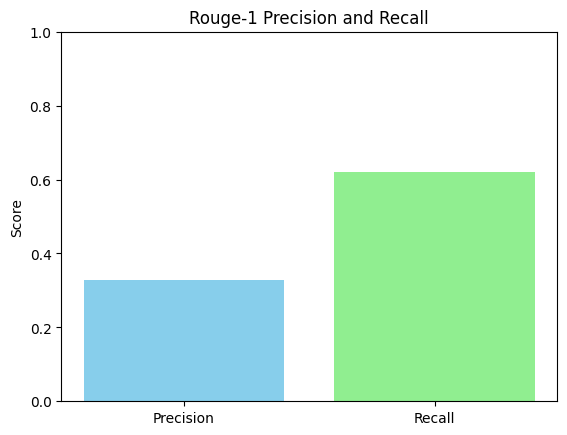

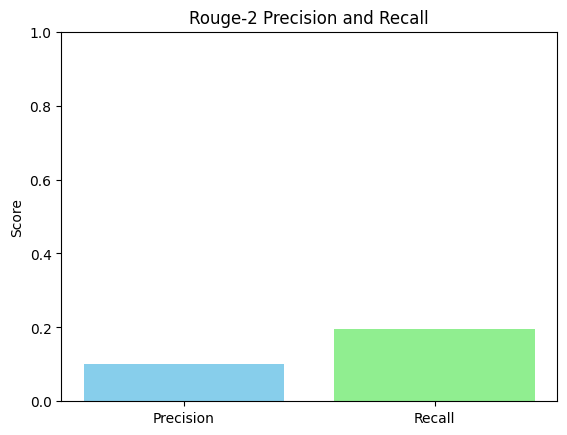

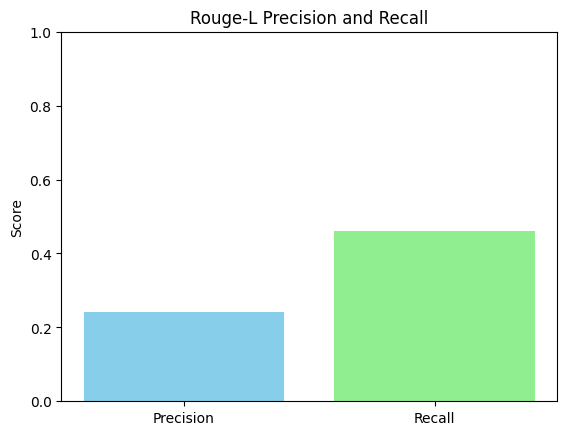

In [ ]:
import matplotlib.pyplot as plt

# Rouge 점수 추출
rouge1_precision = scores["rouge1"].mid.fmeasure
rouge1_recall = scores["rouge1"].mid.recall
rouge2_precision = scores["rouge2"].mid.fmeasure
rouge2_recall = scores["rouge2"].mid.recall
rougeL_precision = scores["rougeL"].mid.fmeasure
rougeL_recall = scores["rougeL"].mid.recall

# Rouge-1 그래프
plt.bar(["Precision", "Recall"], [rouge1_precision, rouge1_recall], color=['skyblue', 'lightgreen'])
plt.title("Rouge-1 Precision and Recall")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

# Rouge-2 그래프
plt.bar(["Precision", "Recall"], [rouge2_precision, rouge2_recall], color=['skyblue', 'lightgreen'])
plt.title("Rouge-2 Precision and Recall")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

# Rouge-L 그래프
plt.bar(["Precision", "Recall"], [rougeL_precision, rougeL_recall], color=['skyblue', 'lightgreen'])
plt.title("Rouge-L Precision and Recall")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


## 전체적인 분석 및 개선 방안 제시

원본 데이터를 가져와서 데이터를 목적에 맞게 전처리를 시키고 문장요약 모델을 LSTM으로 구현하고 어텐션 매커니즘을 추가하여 문장요약을 해보았습니다.
생각보다 성능이 생각보다 좋게 나오지 않았습니다. 여러가지 원인이 있겠지만 모델을 완벽하게 이해하지 못한 부분에서 제가 생각하기에는 전처리 부분에서 최대 텍스트 길이 설정 부분이나, 단어 빈도수를 바탕으로 단어 집합을 만들 때, 크기 설정 부분, 패딩 부분에서 'post' 방식이 아닌 'pre' 방식 사용 정도가 있을 것 같습니다. 전처리 부분을 좀 더 다듬고 학습을 시킨다면 좀 더 좋은 성능이 나올것 같습니다. 그리고 비교적 낮은 에포크임에도 로스율이 떨이지지 않은것으로 보아 오버피팅이 발생하고 있는데, dropout이나 다른 파라미터를 변경하여 성능을 높일 수 있을 것 같습니다.

결론적으로 전체적으로 요약 모델의 성능이 좋지 않다고 판단된다. 성과가 좋지 않은 자연어 요약 모델에는 여러 해결 방안에 대해서 조새해본 내용을 정리해봤습니다.

첫번째로는 우선, seq2seq와 attention mechnism의 조합을 개선하는 것이다.
인코더의 레이어 수를 조정하거나, 디코더에 추가적인 레이어나 컨텍스트 벡터를 도입하여 더 깊고 복잡한 모델을 만들면 문맥 정보를 더 잘 파악할 수 있을 것이다.
그 외에, 양방향 인코더를 사용하여 디코더에 더 많은 정보를 전달하는 경우, 빔서치 크기를 키워 디코더가 더 많은 후보를 고려할 수 있게 하거나, 모델의 학습률이나 임베딩 차원 등과 같은 하이퍼 파라미터를 조정하여 모델을 세밀하게 튜닝하면 모델의 성능을 향상시킬 수도 있다.

두번째로, 워드 임베딩 대신 사전 훈련된 워드 임베딩을 사용하게 되면,
대규모 텍스트 데이터를 사용하여 훈련되었기 때문에, 풍부한 단어 표현이 가능하고
다양한 문맥에서 학습됐으므로, 비슷한 의미를 지닌 단어들이 유사한 벡터 공간에서 가까이 위치하게 된다.
다른 자연어 처리 작업에도 전이 학습으로 활용될 수 있다.
다만, 법률과 같은 특수 분야에선 사전 훈련된 워드 임베딩 보다는, 도메인에 특화된 임베딩이 더 적합하다.
일반적인 언어 사용을 기반으로 다양한 언어의 통계적 패턴을 학습하기 때문에 특정 언어의 문법이나 구조에 최적화되지 않을 수 있다.
즉, 구체적인 도메인이나 언어, 그리고 목적에는 적합하지 않을 수 있다.

세번째로, 빔서치를 seq2seq와 RNN과 함께 이용하게 되면,
빔서치는 주어진 입력에 대해 가능한 모든 시퀀스를 생성하고, 가장 적합한 시퀀스를 선택하는 확률적 탐색이기 때문에, 다양한 해결책을 검토하면서 더 일반화된 요약을 얻을 수 있다.
빔서치는 모델이 다양한 후보를 생성하므로, 탐색 범위도 확장할 수 있고 이는 더 긴 문장이나 더 복잡한 문맥을 처리하는 데 도움이 된다.
다만, 탐색 공간이 매우 크거나 출력 시퀀스의 길이가 매우 긴 경우 계산 비용이 크게 증가하기 때문에 사용하지 않는 것이 좋다.
다양한 후보를 생성하고 유지하기 때문에, 다양한 해결책 보다는 최적의 해결책에 집중해야하는 경우에는 적합하지 않다.
또, 각 단계에서 여러 후보를 유지하기 때문에 중복된 해결책이 발생할 수 있으므로, 중복이 큰 문제가 되는 작업에선 사용하지 않는게 좋다.

모델 훈련 과정에서 런타임이 끊겨서 직접 데이터를 입력하여 진행하였다.
훈련 결과에선 그다지 좋지 못한 요약이 꽤 보인걸로 보아 아쉬운 성능을 가진 모델로 보여진다.
이를 개선하기 위해선 첫번째로는 우선, seq2seq와 attention mechnism의 조합을 개선하는 것이다. 인코더의 레이어 수를 조정하거나, 디코더에 추가적인 레이어나 컨텍스트 벡터를 도입하여 더 깊고 복잡한 모델을 만들면 문맥 정보를 더 잘 파악할 수 있을 것이다. 또 모델의 학습률이나 임베딩 차원 등과 같은 하이퍼 파라미터를 조정하여 모델을 세밀하게 튜닝하면 모델의 성능을 향상시킬 수도 있다.
두번째로는, 워드 임베딩 대신 사전 훈련된 워드 임베딩을 사용하는 것이다. 데이터가 전반적인 뉴스에 대한 요약이므로 성능 향상에 도움이 될 수 있다. 마지막으로 세번째로, 빔서치를 seq2seq와 RNN과 함께 이용하게 되면, 모델이 다양한 후보를 생성하므로, 탐색 범위도 확장할 수 있고 이는 더 긴 문장이나 더 복잡한 문맥을 처리하는 데 도움이 된다.

